# Modelling

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math

from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import xgboost as xgb

from imblearn.over_sampling import SMOTE

import shap

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set max rows and columns display
pd.set_option("display.max_columns", None)

---

In [3]:
# read in csv file
train = pd.read_csv('./data/feature_selected.csv')

In [4]:
train.head()

,latitude,longitude,wnvpresent,year,month,week,day,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_others,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,41.954690,-87.800991,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41.954690,-87.800991,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,41.994991,-87.769279,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [5]:
train.shape

(10506, 185)

## Pre-Processing

### Train-Test-Split
Dataset will be split into train and test for model evaluation. Cross validation will also be done on the train split to further test robustness of model.

In [6]:
y = train['wnvpresent']
X = train.drop(columns=['wnvpresent'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
y_train.value_counts()

0    7466
1     413
Name: wnvpresent, dtype: int64

### Upsampling The Train Set (SMOTE)
Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique used to increase the number of minority samples in imbalanced datasets in a random, balanced manner.

In [9]:
smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [10]:
print(f'Shape before SMOTE: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape after SMOTE: X_train_sm: {X_train_sm.shape}, y_train_sm: {y_train_sm.shape}')

Shape before SMOTE: X_train: (7879, 184), y_train: (7879,)
Shape after SMOTE: X_train_sm: (14932, 184), y_train_sm: (14932,)


In [11]:
y_train_sm.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

## Models
We will define the baseline model and evaluate other built models against each other based on their recall scores. The recall score is a commonly used measure of model performance that weights the count of predicted true positives out of all the actual positive values. 

We are focused on being able to detect true positives so that actions can be taken to address the virus and its vectors effectively. Our cost benefit analysis will be presented in a later part to further illuminate the benefits and major potential cost reduction of such an approach.

### Scoring and Plotting Functions

In [12]:
def scoring(model, classifier_name, X_train, y_train, X_test, y_test):
    nl = '\n'
    
    print(f'{classifier_name} scores:')
    
    train_predict = model.predict(X_train)
    print(f'Train Recall Score: {recall_score(y_train, train_predict)}')
    
    cv_rec = cross_val_score(model, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
    print(f"Cross Val Recall: {cv_rec.mean()}{nl}{cv_rec}{nl}")
    
    test_predict = model.predict(X_test)
    print(f'Test Recall Score: {recall_score(y_test, test_predict)}')
    
    return test_predict

In [13]:
def subplot_matrix_roc(model, classifier_name, X_test, y_test):
    fig, ax= plt.subplots(1,2,figsize=(15,7))

    # plot confusion matrix on left
    ConfusionMatrixDisplay.from_predictions(y_test,predictions,ax=ax[0])
    ax[0].set_title(f'{classifier_name} Confusion Matrix', fontsize=14, weight='bold')

    # plot roc curve on right
    # RocCurveDisplay.from_predictions(y_test,predictions,ax=ax[1])
    RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])

    ax[1].set_title(f'{classifier_name} ROC Curve', fontsize=14, weight='bold')
    #plotting baseline
    ax[1].plot(
        np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        label='Baseline',
        linestyle='--',
        color='red')
    ax[1].legend(loc='best',fontsize=13,)

    plt.tight_layout()

### K Nearest Neighbors Classifier

### Random Forest Classifier

In [14]:
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3,
                                 algorithm='auto',
                                 weights='distance',
                                 p=1,
                                 leaf_size=10))
])

pipe_knn.fit(X_train_sm, y_train_sm)

Pipeline(steps=[('ss', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1,
                                      weights='distance'))])

In [15]:
predictions = scoring(pipe_knn, 'K Nearest Neighbors Classifier', X_train_sm, y_train_sm, X_test, y_test)

K Nearest Neighbors Classifier scores:
Train Recall Score: 0.9263327082775248
Cross Val Recall: 0.907992138233667
[0.83868809 0.94239786 0.93168118 0.91493637 0.9122572 ]

Test Recall Score: 0.2536231884057971


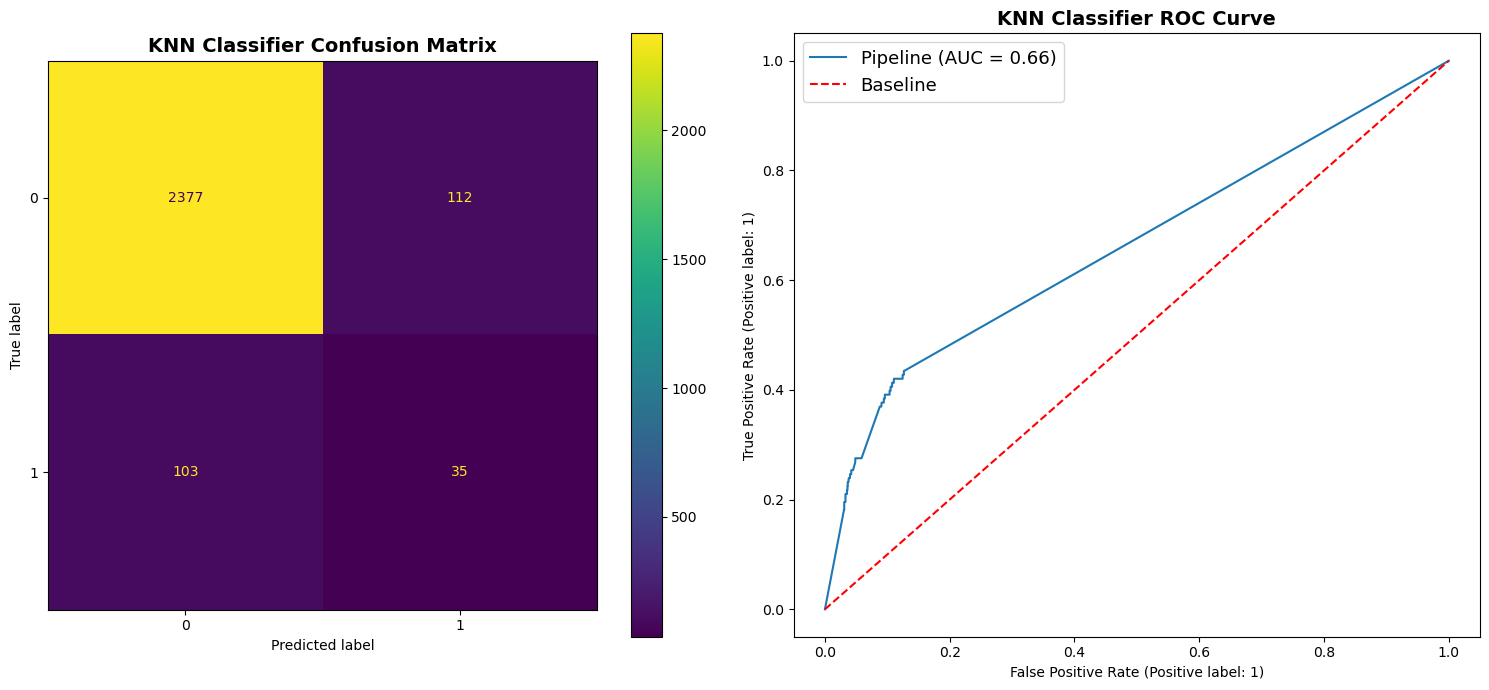

In [16]:
subplot_matrix_roc(pipe_knn, 'KNN Classifier', X_test, y_test)

In [17]:
rf = RandomForestClassifier(n_estimators=10, random_state= 42, max_depth=3)
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [18]:
predictions = scoring(rf, 'Random Forest Classifier', X_train_sm, y_train_sm, X_test, y_test)

Random Forest Classifier scores:
Train Recall Score: 0.8446289847307795
Cross Val Recall: 0.860568148907306
[0.85876841 0.85264568 0.88345613 0.83255191 0.87541862]

Test Recall Score: 0.7898550724637681


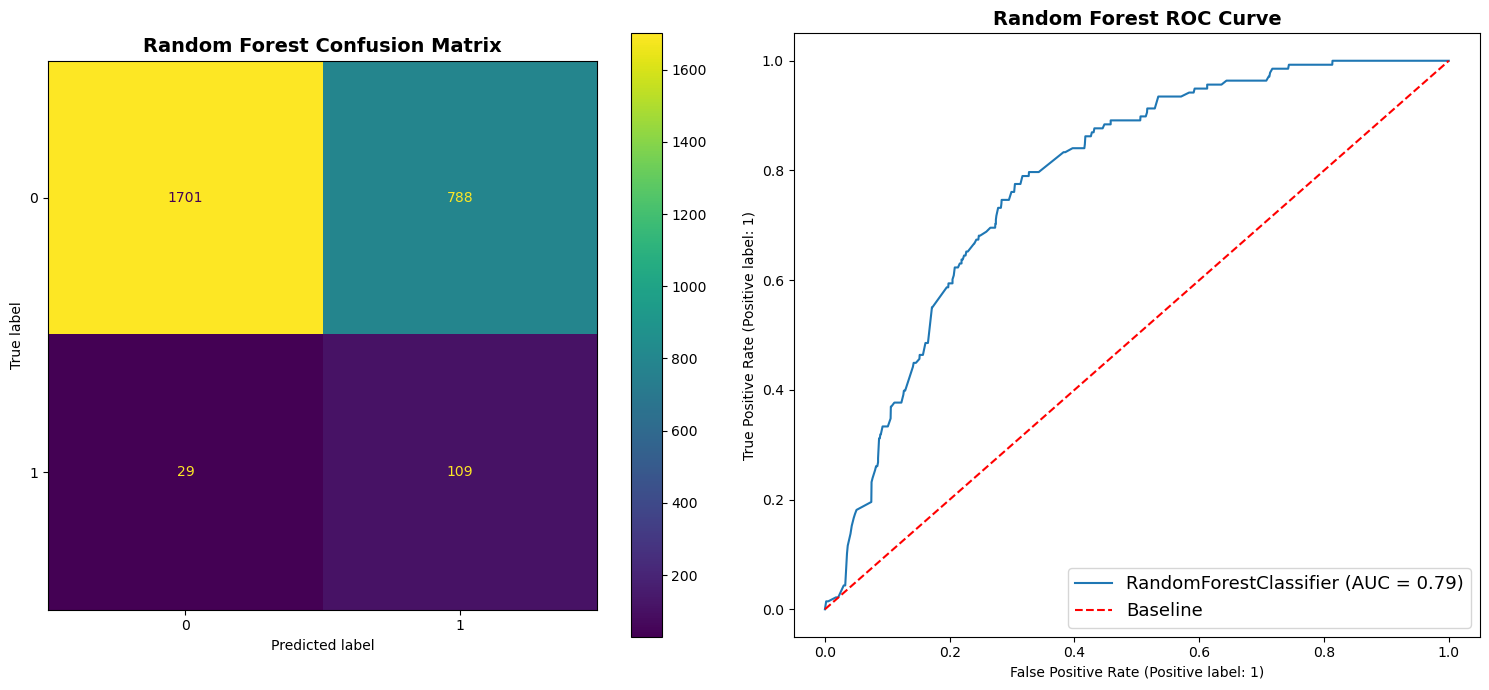

In [19]:
subplot_matrix_roc(rf, 'Random Forest', X_test, y_test)

### AdaBoost

In [20]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=42)
ada.fit(X_train_sm, y_train_sm)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)

In [21]:
predictions = scoring(ada, 'Adaboost', X_train_sm, y_train_sm, X_test, y_test)

Adaboost scores:
Train Recall Score: 0.9217787302437718
Cross Val Recall: 0.9181762997513608
[0.81392236 0.94440723 0.94172806 0.94440723 0.94641661]

Test Recall Score: 0.4420289855072464


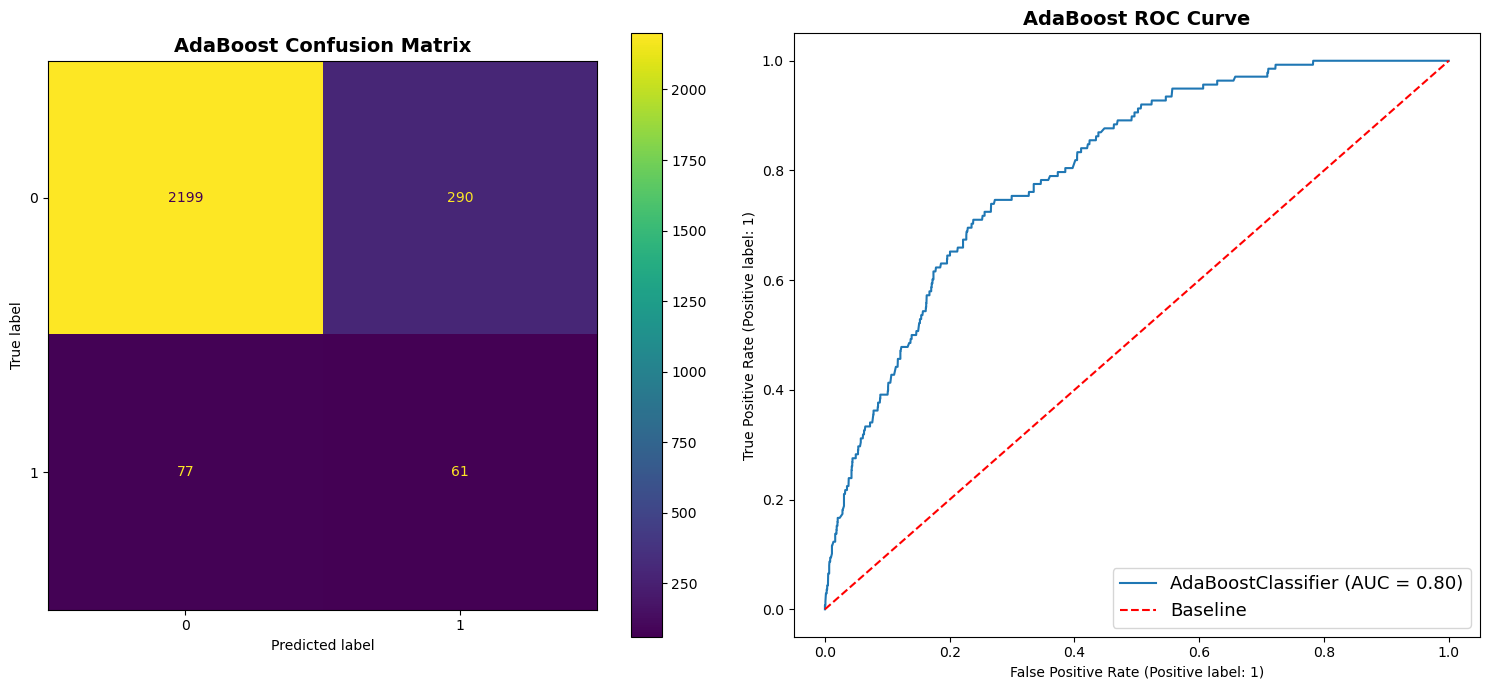

In [22]:
subplot_matrix_roc(ada, 'AdaBoost', X_test, y_test)

### XGBoost

In [23]:
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.2, n_estimators=1000, objective='binary:logistic', gamma=1, random_state=42) #nthread=1
clf.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [24]:
predictions = scoring(clf, 'XGBoost', X_train_sm, y_train_sm, X_test, y_test)

XGBoost scores:
Train Recall Score: 0.9667827484596839
Cross Val Recall: 0.9483226049991437
[0.77175368 0.99464166 0.98928332 0.99263228 0.99330208]

Test Recall Score: 0.26811594202898553


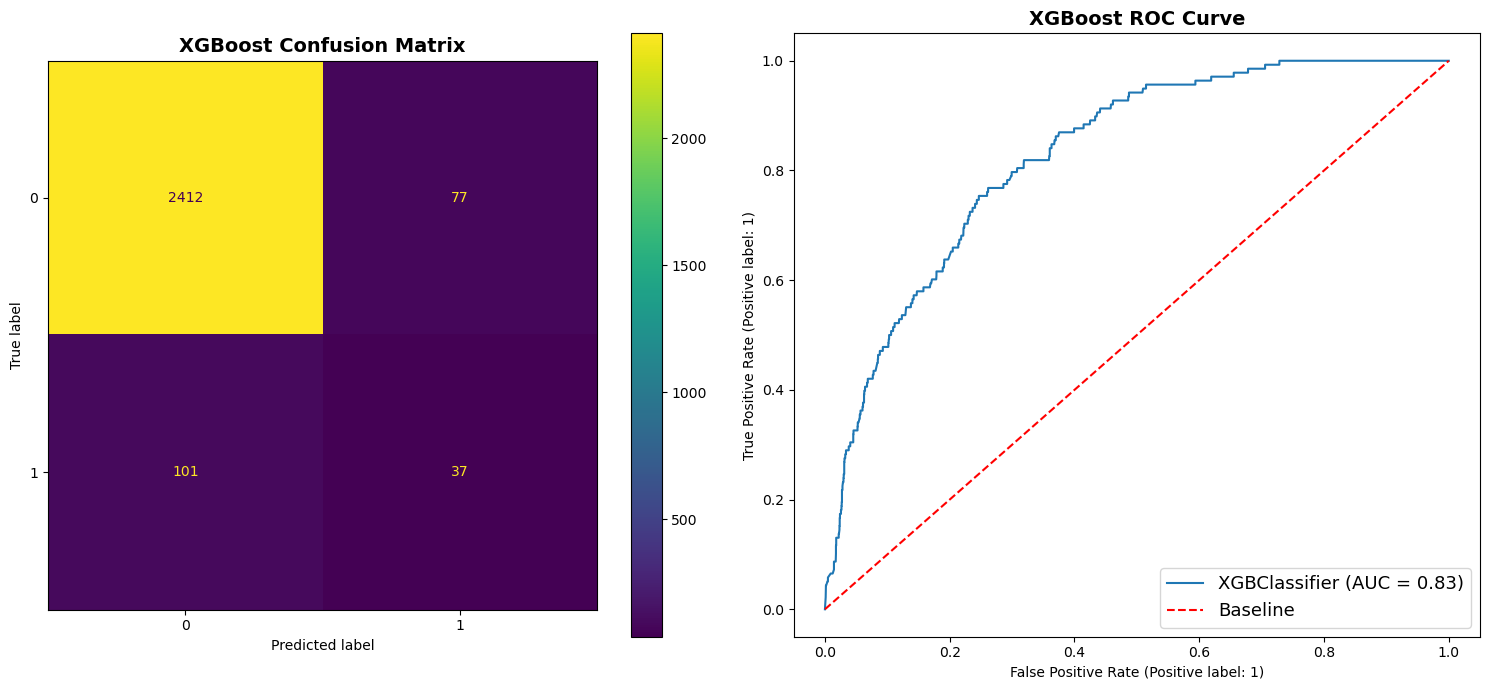

In [25]:
subplot_matrix_roc(clf, 'XGBoost', X_test, y_test)

## Tuning Best Model
Random Forest performed the best in terms of recall score. We will as such tune its hyperparameters to further optimize the model.

In [26]:
rf = RandomForestClassifier(max_depth=3,max_features='auto',min_samples_split=2,n_estimators=100,random_state= 42, n_jobs=-1)
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=42)

In [27]:
# Gridsearch performed
# rf = RandomForestClassifier(random_state= 42, n_jobs=-1)

# param = {'max_depth': [3,6,9],
#  'max_features': ['auto'],
#  'min_samples_split': [2,4,6],
#  'n_estimators': [20,50,100]}

# rf_gs = GridSearchCV(rf, param, cv=5, n_jobs=-1, verbose=1, scoring='recall')
# rf_gs.fit(X_train_sm, y_train_sm)

# print(f'Best model parameters: ', rf_gs.best_params_)
# print(f'Cross validation score: ', rf_gs.best_score_)

In [28]:
predictions = scoring(rf, 'Random Forest', X_train_sm, y_train_sm, X_test, y_test)

Random Forest scores:
Train Recall Score: 0.8580230377712296
Cross Val Recall: 0.854406507476658
[0.85542169 0.87206966 0.84728734 0.83657066 0.86068319]

Test Recall Score: 0.7971014492753623


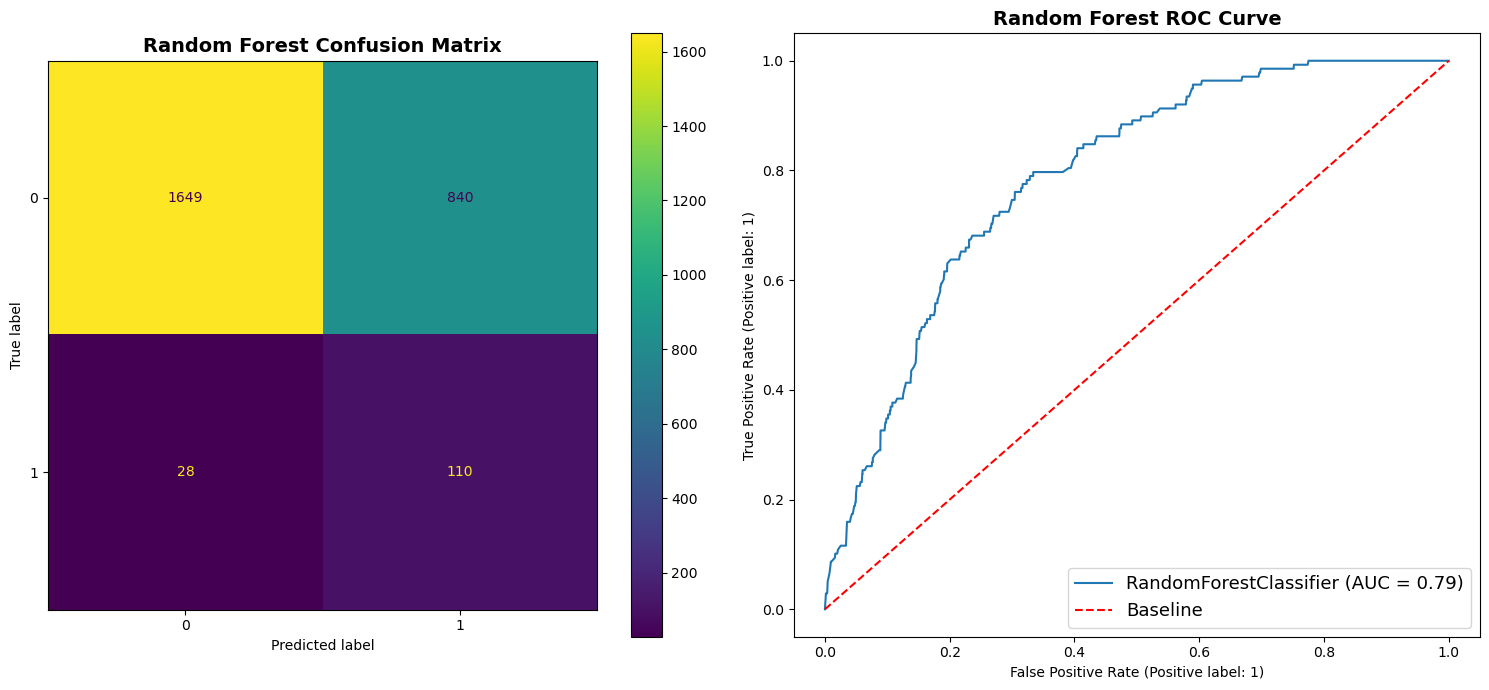

In [29]:
subplot_matrix_roc(rf, 'Random Forest', X_test, y_test)

## Evaluation

### Recall
Recall score is used as a measure of model performance in terms of correctly identifying the positive class out of all the actual positives. Recall is a more objective metric for imbalanced datasets and is also apt because of our greater interest in identifying true positives. <b>Mathematically, Recall is the number of relevant documents retrieved by a search divided by the total number of existing relevant documents.</b>

Optimizing for recall allows us to use the model to reduce the number of areas to spray while ensuring that we have a low miss rate on areas that actually have the West Nile Virus present. This is in line with the huge benefits that mosquito control has in terms of reducing various costs; from lost labour due to sick days up to massive medical costs and loss of life from potentially serious complications.

The table shown below shows the recall scores attained by each model, with Random Forest emerging triumphant over the others in terms of test recall score. Random Forest cleared the benchmark KNN model by a decent margin as well. While the other models seemed to perform better in train and cross validation, their performance dips sorely on the test set, suggesting gross overfitting.

|Model|Train Recall|Test Recall|
|:---:|:---:|:---:|
|**Random Forest (tuned)**|0.86|0.80|
|||||||
|KNN (baseline)|0.92|0.25|
|||||||
|AdaBoost|0.92|0.44|
|||||||
|XGBoost|0.96|0.25|

## Kaggle
In line with the project requirements we will be predicting on the test dataset provided and submitting it in the format specified by Kaggle.

In [30]:
# # upsample entire test dataset
# # refit selected model on entire test dataset
# rf.fit()

In [31]:
# load in test
test = pd.read_csv('./data/test_prepped.csv')

In [32]:
test.shape

(116293, 185)

In [33]:
kaggle_test = test.drop('id', axis=1)

In [34]:
# kaggle_test = kaggle_test[features]

In [35]:
pred = rf.predict(kaggle_test)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
submission_test = pd.DataFrame({'ID': test.id, 'WnvPresent': pred})
print(submission_test.shape)
print(submission_test.head())

(116293, 2)
   ID  WnvPresent
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0


In [37]:
submission_test.groupby('WnvPresent').count()

,ID
WnvPresent,
0,77495
1,38798


In [38]:
submission_test.to_csv('test_sub.csv', index=False)

## Cost Benefit Analysis

---

### Background

In the continental United States, West Nile Virus (WNV) is the most common form of mosquito-borne disease. It is spread to people via the bite of an infected mosquito, and is as such much more prevalent during mosquito season which starts in the summer and continues through fall. This is unsurprisingly likely due to greater presence of its primary vector, the culex mosquito, during this period of time. There are currently **no vaccines to prevent WNV nor medications available to treat it**. 

Fortunately, most people infected with WNV do not experience any major symptoms. 1 in 5 infected however, do develop a fever among other symptoms such as joint pain and about 1 out of 150 infected develop a serious, sometimes fatal, illness.<a href="https://www.cdc.gov/westnile/index.html#:~:text=There%20are%20no%20vaccines%20to,serious%2C%20sometimes%20fatal%2C%20illness."><sup>1</sup></a>

---
### Existing Efforts

The CDPH Environmental Health program has been performing targeted insecticide spraying of adult mosquitoes (adulticiding) from July through late August. The brand of adulticide used is Zenivex® and this is used at a rate of 1.5 fluid ounces per acre<a href="https://abc7chicago.com/archive/9206273/"><sup>2</sup></a>.

---
### Implementation Costs
**Direct Cost: Cost of Adulticide** 

Zenivex costs \$299.80/gl.<a href="https://www.gfmosquito.com/wp-content/uploads/2017/07/2017-ND-Mosq.-Control-Quotes-Tabulation.pdf"><sup>3</sup></a> This translates to a cost of \$3.51 per acre, scaling up to **$526,851** if applied throughout Chicago (150,100 acres).

**Indirect Cost: Environmental Concerns**

While people may be concerned about the environmental and health impact of mosquito control, pesticides and their labeling are constantly under review and require approval from the US Environmental Protection Agency (USEPA) before use. This is done to protect public health and further ensures that application methods minimize the risk of human exposure as well as adverse environmental effects. In fact, there is generally no need to relocate during mosquito control fogging<a href="https://dph.illinois.gov/topics-services/environmental-health-protection/structural-pest-control/mosquito-spray-faqs.html"><sup>4</sup></a>. Potential health and environmental costs are as such minimal.

---
### Implementation Benefits
**Reduction in Medical Costs and Loss of Productivity**

The median medical cost for a patient with WNV non-neuroinvasive disease (vanilla WNV disease) was \\$4,467 while the median cost for a patient with acute flaccid paralysis (serious complication) was \$20,774<a href="https://www.ajtmh.org/view/journals/tpmd/90/3/article-p402.xml"><sup>5</sup></a> in the United States. Majority of the total costs were incurred as hospital charges.

On a larger scale, extrapolated findings of a study on 2003 WNV data estimates that hospitalized cases of WNV disease have an **annual burden of \$56 million** in the United States<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945683/"><sup>6</sup></a>. Long-term direct and indirect medical costs after the initial illness can be extremely costly, depending on the severity of the illness and complications. While only a small subset of patients do end up with serious conditions, ranging from meningitis to acute flaccid paralysis, the costs to these individuals can easily runup to an amount much larger than the initial illness and hospitalization<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945683/"><sup>7</sup></a>.

This also draws down on available healthcare resources and is not an ideal situation to be in for an entire 5-month season.

**Preventing Proliferation of Disease Vectors**

While Culex mosquitoes are unable to fly far, letting them breed and feed freely during the peak season is a dangerous game to play. Most mosquito-borne diseases proliferate with increased mosquito count and host-vector contact. Keeping mosquito populations low, especially in dense and urbanized areas is also an effective way to prevent further spread and maintenance of disease hotspots.

---
### Analysis

Taking into consideration the various costs and benefits of an effective spraying plan, the direct net benefits alone appear to amount in the millions. Additionally, indirect benefits such as peace of mind are hard to quantify but equally important. Constantly getting bitten by mosquitoes over 5 months isn't the most enjoyable experience either.

---
### Further Cost Savings

In its current iteration, the seasonal mosquito spraying program in Chicago is already highly beneficial, particularly when compared to its cost. However, spraying efforts can be further streamlined to reduce direct costs.

Rather than the current spray and pray method, using our model as a guide to decide on spraying areas on demand can help to reduce costs by preventing overspraying. A Recall score of 0.80 implies that the model is quite capable in ensuring that areas with WNV are not missed. While the model isn't particularly high on precision, the extra cost of a false positive (extra spraying) is much lower than that of a false negative.

### Feature Importance

In [39]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)

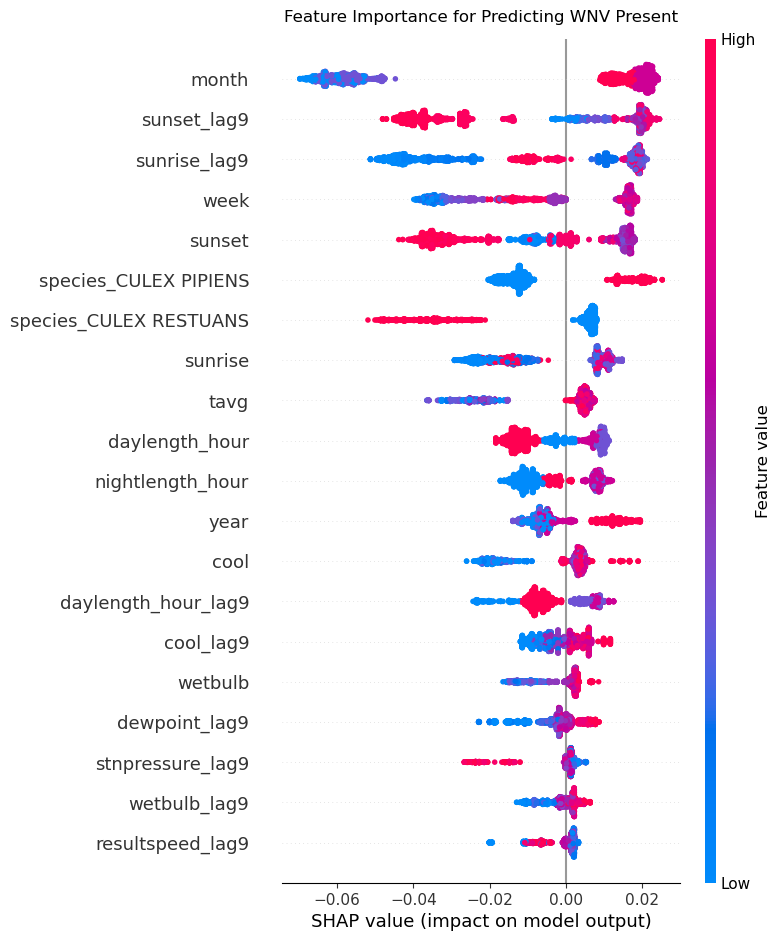

In [40]:
plt.title("Feature Importance for Predicting WNV Present", y=1.01)
shap.summary_plot(shap_values[1], X_test)

*Interpretation:*

The SHAP value Beeswarm plot above shows the features that have the highest impact on model prediction. 

In line with what we found in EDA, peak mosquito season occurs in the 3rd quarter of the year. These months are thus more predictive of positive WNV presence and is illustrated by the purplish brocolli head on the right side of the line for the month feature. Months in the early part of the year however is seen as having a negative impact in terms of predicting for WNV presence.

Sunset and sunrise related features such as day and night length rank quite highly in terms of feature importance. Culex mosquitos are typically night biters, so the length of day/night affects their activities. Of slightly more interest here is the 9-day-lagged day length feature. The shortest days have the largest impact on predicting for absence of WNV 9 days later, which appears contrary to mosquito activity. A possible explanation could be that since warmer temperatures are associated with accelerated mosquito develpoment, biting rates, and the incubation of the disease within a mosquito, days of a certain length provide the optimal heating environment that keeps the temperature comfortable for mosquitoes throughout the night. Colder seasons where mosquitoes do not thrive are also associated with shorter days, so that might be another reason as well.

The presence of Culex Pipiens, one of the primary vectors of WNV transmission in the US, is unsurprisingly a strong predictor of the presence of WNV. 

### Recommendations

1. Identify more precisely when mosquito season is about to pick up in Q3 of each year and remind citizens to keep up with their protective/preventive strategies.


2. Enhance on the ground surveillance for mosquito breeding grounds. As recommended to all states by the CDC, Chicago should also employ professionals to conduct inspections for mosquito breeding areas during the high season. This will help supplement adulticiding efforts.


3. Use the model as a preliminary guide in deciding spray areas. The model can be used to predict the possible presence of WNV based on weather and trap related observations to be collected by the surveillance team. This would guide efforts in identifying hotspots by narrowing down the search area

### Conclusion
To recap our problem statement, as part of DATA-SCIENCE we are aiming to develop a model that can accurately predict the presence of WNV based on weather and temporal features to help Chicago and the CDPH more efficiently allocate resources to effectively prevent transmission of this harmful virus.

A summary of key data analysis insights:

1. In general, the plots for 2007 and 2013 showed more sharp peaks and decline because WNV was more prevalent in these years as seen from the bar plot at the beginning of our analysis.

2. Temperature seems to play an important factor in the proliferation of WNV. Higher temperatures (>60 degrees fahrenheit) would contributes to higher prevalence of WNV and number of mosquitoes with WNV.

3. Lower average and resultant wind speed (<10 mph) contributes to higher number of mosquitoes and the prevalence of WNV.

4. Lower total precipitation (<1.0 inch) contributes to higher prevalence of WNV and number of mosquitoes with WNV.

Following exploratory data analysis, we proceeded to engineer some relevant features and built several models. Our Random Forest Classifier model was ultimately evaluated as the best performing for our purpose and was hence selected as the production model since it fulfilled both criteria outlined in the problem statement (Recall > 0.75 & better performance than baseline model). This selected model achieved a recall score of 0.80 on the hold-out test set with minimal data pre-processing and feature engineering required. 

Through a cost benefit analysis, we were able to deduce that the overall benefit brought through the implementation of a spray-based mosquito control program outweighs its costs by a large margin. The model we built is also able to help streamline these efforts by providing some guidance on potential hotspots and allowing for more precise prediction on the start of mosquito season. 

The project can be considered a success since the aims outlined at the start were achieved. We hope that our work will be used to inform important mosquito-control-related decisions and help the CDPH more efficiently allocate resources to effectively prevent transmission of this potentially deadly virus. Stay safe, Chicago.

### Future Directions
1. Projected costs of WNV prevention may differ for different years. This means that the cost benefit analysis should be reviewed from time to time.


2. The current dataset used in analysis and model building only focuses on weather features and trap-based data. Additional data might be useful in increasing the predictive ability of the model. One such example would be observations regarding reports on dead birds since WNV incubates in birds.


3. Some of the findings in our project can be included in educational materials to help the general public understand conditions favourable to culex mosquito breeding and hence WNV propagation.


4. This project is explicitly focused on spraying programs. Research into other mosquito-control methods can be done to supplement these efforts.